In [1]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image

## Facial attribute dataset loading
dataset of images of faces of celeberities used as input to model and output are landmark points for the person's face used to characterize the facial attributes

In [2]:
key_points_data_path = "Data/list_landmarks_align_celeba.csv"
images_data_path = "Data/img_align_celeba/"
images_data_size = 5000  # We take a subsample of 5000 images from the dataset
# Original image dimensions
x_org = 178    
y_org = 218    

# New image dimensions - to control the resolution parameter of mobilenet (keep varying)
x_ = 128                          
y_ = 128

original_image_size = (x_org, y_org)
new_image_size = (x_,y_)

# The image size that will be used in the training process
image_size_training = new_image_size

In [3]:
import pandas as pd
df_org = pd.read_csv(key_points_data_path)
df_org = df_org[:images_data_size]

In [4]:
# Forming the dataset
images_data = list()
for idx in range(df_org.shape[0]):
    path = "{}/{}".format(str(images_data_path),str(df_org.iloc[idx].image_id))
    
    # Reading images using PIL library
    image = PIL.Image.open(path).resize(image_size_training) #resizing the image to required resolution
    image_array = np.asarray(image) / 255  #normalizing the pixel values

    images_data.append(image_array)
    
# Converting images_data to an array from list
images_data = np.array(images_data)

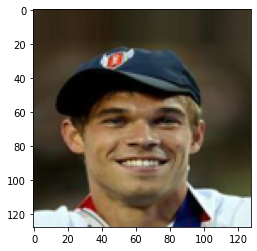

In [5]:
plt.imshow(images_data[500])

In [6]:
print("Images Data Arrays Shape:", images_data.shape)
print("Key Points Data Shape:", df_org.shape)

Images Data Arrays Shape: (5000, 128, 128, 3)
Key Points Data Shape: (5000, 11)


In [7]:
# function to read images based on index
def image_array(index, size=image_size_training, path=images_data_path):
    path = "{}/{}".format(str(path),str(df_org.iloc[index].image_id))
    
    # to read the image
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)
    
    return image_array

In [8]:
# function to get a list of all key points of the face
def image_key_points_list(index, df = df_org):
    points_list = [df.iloc[index].lefteye_x,
                   df.iloc[index].lefteye_y,
                   df.iloc[index].righteye_x,
                   df.iloc[index].righteye_y,
                   df.iloc[index].nose_x,
                   df.iloc[index].nose_y,
                   df.iloc[index].leftmouth_x,
                   df.iloc[index].leftmouth_y,
                   df.iloc[index].rightmouth_x,
                   df.iloc[index].rightmouth_y]
    
    return points_list

In [9]:
# function to plot the image with green box around the faces
def plotting_image_with_box(index, df = df_org, size=original_image_size):
    
    test_image = image_array(index, size)
    points_list = image_key_points_list(index, df)
    
    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]
    
    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], 'bo-')
    
    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor='g', facecolor='none')
    ax.add_patch(rect);

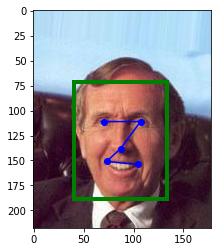

In [10]:
plotting_image_with_box(20)

## Labels Dataset Preparation
Output will be 10 landmark points for each image of a celebrity's face used to characterize the facial attributes

In [11]:
df = df_org.copy()
df.head(3)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158


In [12]:
# function for updating key points for a new size
def rescale_key_points(oldsize=original_image_size, newsize=image_size_training):
    # old and nwe sizes (x,y) values
    x_axis_old = oldsize[0]
    y_axis_old = oldsize[1]

    x_axis_new = newsize[0]
    y_axis_new = newsize[1]

    x_ratio = x_axis_new / x_axis_old
    y_ratio = y_axis_new / y_axis_old
    
    # converting the keypoints values to be trained with the new size of the images
    keypoints_x = ['lefteye_x', 'righteye_x', 'nose_x', 'leftmouth_x', 'rightmouth_x']
    keypoints_y = ['lefteye_y', 'righteye_y', 'nose_y', 'leftmouth_y', 'rightmouth_y']
    
    df[keypoints_x] = (df[keypoints_x] * x_ratio).astype('int')
    df[keypoints_y] = (df[keypoints_y] * y_ratio).astype('int')
    
    return 0

rescale_key_points()

df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,49,64,76,66,55,83,52,89,77,90
1,000002.jpg,49,64,76,65,58,79,50,88,77,89
2,000003.jpg,54,65,74,62,77,75,53,91,70,92
3,000004.jpg,51,66,77,63,72,81,51,91,72,88
4,000005.jpg,47,66,80,65,61,69,51,86,74,88


## Train - Test Data Preparation

In [13]:
from sklearn.model_selection import train_test_split
images=images_data
labels=df
train_images,test_images,train_labels,test_labels=train_test_split(images,labels,
                                                                  test_size=0.3,random_state=42)

In [14]:
y_test=test_labels.drop(["image_id"],axis=1)
y_train=train_labels.drop(["image_id"],axis=1)

X_test=test_images
X_train=train_images

In [15]:
X_test, X_val, y_test, y_val=train_test_split(X_test, y_test,
                                              test_size=0.5,random_state=42)

In [16]:
x_ = image_size_training[0]
y_ = image_size_training[1]

## Transfer Learning with MobileNet

In [17]:
import tensorflow as tf
model = tf.keras.applications.MobileNet(input_shape= (y_, x_, 3), alpha=0.75,
                                               include_top=False,
                                               weights='imagenet') #keep changing values of alpha and input_shape
model.summary()

Model: "mobilenet_0.75_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 24)        648       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 24)        96        
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 24)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 24)        216       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 24)        96        
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 24) 

In [18]:
model.trainable = False

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(10, activation='relu')

In [20]:
model = tf.keras.Sequential([
  model,
  global_average_layer,
  prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_0.75_128 (Function (None, 4, 4, 768)         1832976   
_________________________________________________________________
global_average_pooling2d (Gl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7690      
Total params: 1,840,666
Trainable params: 7,690
Non-trainable params: 1,832,976
_________________________________________________________________


In [21]:
model.compile(optimizer="rmsprop", loss='mean_squared_error',metrics=['mean_absolute_percentage_error'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)


reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [earlystop,reduceLR]

In [23]:
hisotry = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=4, shuffle=True)

Epoch 1/10
875/875 [==============================] - 23s 25ms/step - loss: 602.7159 - mean_absolute_percentage_error: 20.9012 - val_loss: 33.0899 - val_mean_absolute_percentage_error: 6.3192
Epoch 2/10
875/875 [==============================] - 22s 25ms/step - loss: 27.3616 - mean_absolute_percentage_error: 5.7584 - val_loss: 21.8918 - val_mean_absolute_percentage_error: 5.1698
Epoch 3/10
875/875 [==============================] - 21s 24ms/step - loss: 20.2583 - mean_absolute_percentage_error: 4.9587 - val_loss: 19.0397 - val_mean_absolute_percentage_error: 4.8237
Epoch 4/10
875/875 [==============================] - 21s 24ms/step - loss: 17.5448 - mean_absolute_percentage_error: 4.6052 - val_loss: 17.4773 - val_mean_absolute_percentage_error: 4.5999
Epoch 5/10
875/875 [==============================] - 21s 24ms/step - loss: 16.1036 - mean_absolute_percentage_error: 4.4072 - val_loss: 16.4971 - val_mean_absolute_percentage_error: 4.4674
Epoch 6/10
875/875 [============================

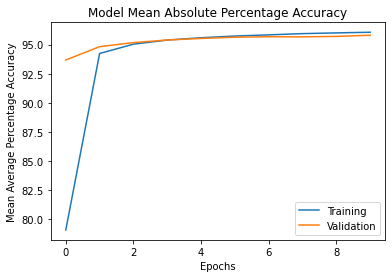

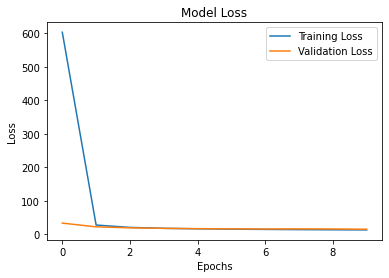

In [31]:
plt.subplot()
plt.title('Model Mean Absolute Percentage Accuracy')
plt.plot([100-val for val in hisotry.history['mean_absolute_percentage_error']])
plt.plot([100-val for val in hisotry.history['val_mean_absolute_percentage_error']])
plt.ylabel('Mean Average Percentage Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.show()

plt.title('Model Loss')
plt.plot(hisotry.history['loss'])
plt.plot(hisotry.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.show()

## Plotting Sample Predictions

In [32]:
def predictions_test_model(index):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_,x_,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    points_list = model.predict(img.reshape(1,y_,x_,3)).astype('int')[0]
    
    # converting key points values to the original size
    x_ratio = 1.05 * (original_image_size[0] / image_size_training[0])
    y_ratio = 1.085 * (original_image_size[1] / image_size_training[1])
   
    
    points_list[0] = int(points_list[0] * x_ratio)
    points_list[2] = int(points_list[2] * x_ratio)
    points_list[4] = int(points_list[4] * x_ratio)
    points_list[6] = int(points_list[6] * x_ratio)
    points_list[8] = int(points_list[8] * x_ratio)
    
    points_list[1] = int(points_list[1] * y_ratio)
    points_list[3] = int(points_list[3] * y_ratio)
    points_list[5] = int(points_list[5] * y_ratio)
    points_list[7] = int(points_list[7] * y_ratio)
    points_list[9] = int(points_list[9] * y_ratio)
    
    return points_list

In [33]:
# function to plot the image with box around the faces
def test_image_with_box_plot(index, pred_or_actual = 'pred', pointsColor='bo-' ,boxcolor='g'):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_org,x_org,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    test_image = img/255
    
    # predictions of key points on the face
    if pred_or_actual == 'pred':
        points_list = predictions_test_model(index)        # this for predections of the model
    elif pred_or_actual == 'actual':
        points_list = image_key_points_list(index)   # this for the actual labels of the test data
    
    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]

    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], pointsColor)
    
    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor=boxcolor, facecolor='none')
    ax.add_patch(rect);
    return points_list

array([ 73, 121, 115, 121,  94, 144,  71, 166, 115, 164])

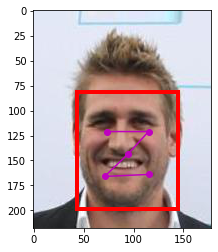

In [37]:
# Using the model to predict a sample image
index = 34200 
test_image_with_box_plot(index, pred_or_actual = 'pred', pointsColor='mo-' ,boxcolor='r')